In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
# Set the Optuna logger to output only warnings or higher level messages
optuna.logging.set_verbosity(optuna.logging.WARNING)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

experiment = 'cap_outliers'

import warnings
warnings.filterwarnings("ignore")

c:\Users\Adeniyi Babalola\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [3]:
train.describe([0.01, 0.99]).T

,count,mean,std,min,1%,50%,99%,max
id,10407.0,5203.000000,3004.386460,0.0,104.060000,5203.000000,10301.940000,10406.000000
allelectrons_Total,10407.0,128.053516,224.123776,0.0,6.000000,100.000000,719.400000,15300.000000
density_Total,10407.0,14.491342,15.972877,0.0,0.739942,10.650000,75.098979,643.093804
allelectrons_Average,10407.0,17.033222,10.468734,0.0,4.666667,12.600000,50.000000,67.000000
val_e_Average,10407.0,4.546789,0.690864,0.0,2.000000,4.714286,5.666667,6.000000
atomicweight_Average,10407.0,37.507703,26.012313,0.0,8.773227,26.203827,119.629500,167.400000
ionenergy_Average,10407.0,10.938308,1.408276,0.0,8.054000,11.202760,13.512520,15.245810
el_neg_chi_Average,10407.0,2.607662,0.334906,0.0,1.790000,2.706000,2.980000,3.443000
R_vdw_element_Average,10407.0,1.731330,0.192481,0.0,1.318667,1.732727,2.055000,2.250000
R_cov_element_Average,10407.0,0.944132,0.180017,0.0,0.505333,0.915556,1.390000,1.615840


In [4]:
# Constants
TARGET = 'Hardness'

In [5]:
# Selecting numerical variables from the train dataset, excluding 'id' and TARGET
num_var = train.drop(['id', TARGET], axis=1).select_dtypes(include=np.number).columns
print(num_var)

Index(['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average'],
      dtype='object')


In [6]:
# Combining train and test datasets for comparative analysis
# 'Source' column is added to label data from each dataset
df = pd.concat([
    train[num_var].assign(Source='Train'), 
    test[num_var].assign(Source='Test')
], axis=0, ignore_index=True)

In [7]:
# Check for outliers
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    IQR = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * IQR
    low_limit = quartile1 - 1.5 * IQR
    print(f'Feature name: {col_name}')
    print(f'Low Limit: {low_limit}')
    print(f'Upper Limit: {up_limit}')
    print()
    return low_limit, up_limit


def remove_outlier(dataframe, col_name):
    """
    Example Usage:
    for col in num_cols:
    new_df = remove_outlier(titanic, col)
    """
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]    
    return df_without_outliers

def cap_outliers(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)

    dataframe[col_name] = np.where(dataframe[col_name] > up_limit, up_limit, 
                                   np.where(dataframe[col_name] < low_limit, low_limit, dataframe[col_name]))
    return dataframe

df_capped = train.copy()
for col in num_var:
    df_capped = cap_outliers(df_capped, col)

Feature name: allelectrons_Total
Low Limit: -1064.1000000000076
Upper Limit: 1789.5000000000127

Feature name: density_Total
Low Limit: -110.79861331237501
Upper Limit: 186.637534387425

Feature name: allelectrons_Average
Low Limit: -63.333333333333336
Upper Limit: 118.0

Feature name: val_e_Average
Low Limit: -3.5000000000000018
Upper Limit: 11.16666666666667

Feature name: atomicweight_Average
Low Limit: -157.51118333333332
Upper Limit: 285.91391

Feature name: ionenergy_Average
Low Limit: -0.1337799999999998
Upper Limit: 21.7003

Feature name: el_neg_chi_Average
Low Limit: 0.0050000000000001155
Upper Limit: 4.765

Feature name: R_vdw_element_Average
Low Limit: 0.21416666666666706
Upper Limit: 3.1595

Feature name: R_cov_element_Average
Low Limit: -0.8216666666666667
Upper Limit: 2.7169999999999996

Feature name: zaratio_Average
Low Limit: -0.047446360606061166
Upper Limit: 1.160072823232324

Feature name: density_Average
Low Limit: -11.648170499999999
Upper Limit: 19.7675743



In [8]:
df_capped.describe([0.01, 0.99]).T

,count,mean,std,min,1%,50%,99%,max
id,10407.0,5203.000000,3004.386460,0.000000,104.060000,5203.000000,10301.940000,10406.000000
allelectrons_Total,10407.0,125.050950,122.817572,0.000000,6.000000,100.000000,719.400000,1789.500000
density_Total,10407.0,14.433119,14.640489,0.000000,0.739942,10.650000,75.098979,186.637534
allelectrons_Average,10407.0,17.033222,10.468734,0.000000,4.666667,12.600000,50.000000,67.000000
val_e_Average,10407.0,4.546789,0.690864,0.000000,2.000000,4.714286,5.666667,6.000000
atomicweight_Average,10407.0,37.507703,26.012313,0.000000,8.773227,26.203827,119.629500,167.400000
ionenergy_Average,10407.0,10.938308,1.408276,0.000000,8.054000,11.202760,13.512520,15.245810
el_neg_chi_Average,10407.0,2.607694,0.334655,0.005000,1.790000,2.706000,2.980000,3.443000
R_vdw_element_Average,10407.0,1.732730,0.180280,0.214167,1.318667,1.732727,2.055000,2.250000
R_cov_element_Average,10407.0,0.944132,0.180017,0.000000,0.505333,0.915556,1.390000,1.615840


#### No missing data in the both train and test datasets

In [9]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import median_absolute_error, make_scorer
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import LogisticRegression, RidgeCV, PassiveAggressiveRegressor, SGDRegressor, Perceptron, LinearRegression, TheilSenRegressor, HuberRegressor, RANSACRegressor, Lasso, ElasticNet, Lars, LassoLars, OrthogonalMatchingPursuit, BayesianRidge, ARDRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn import svm

MLA = [
	# Trial Models
	MLPRegressor(random_state=5),
	TheilSenRegressor(random_state=5),
	HuberRegressor(),
	RANSACRegressor(random_state=5),
	Lasso(random_state=5),
	ElasticNet(random_state=5),
	Lars(random_state=5),
	LassoLars(random_state=5),
	OrthogonalMatchingPursuit(),
	BayesianRidge(),
	ARDRegression(),

	# GLM
	LinearRegression(),
	PassiveAggressiveRegressor(random_state=5),
	RidgeCV(),
	# SGDRegressor(),

	# SVM
	svm.SVR(),
	svm.NuSVR(),

	# Trees    
	DecisionTreeRegressor(random_state=5),
	ExtraTreeRegressor(random_state=5),

	XGBRegressor(random_state=5),
	LGBMRegressor(n_jobs=-1, random_state=5),
	CatBoostRegressor(random_state=5, verbose=False, early_stopping_rounds=100),
	
	# KNeighbors
	KNeighborsRegressor(),
	KNeighborsRegressor(n_neighbors=2),
	KNeighborsRegressor(n_neighbors=4),
	KNeighborsRegressor(n_neighbors=8),
	KNeighborsRegressor(n_neighbors=16),
	KNeighborsRegressor(n_neighbors=32),
	KNeighborsRegressor(n_neighbors=64),
	KNeighborsRegressor(n_neighbors=128),
	KNeighborsRegressor(n_neighbors=256),
	KNeighborsRegressor(n_neighbors=512),
	KNeighborsRegressor(n_neighbors=1024),

	# Ensemble Methods
	AdaBoostRegressor(random_state=5),
	BaggingRegressor(random_state=5),
	ExtraTreesRegressor(random_state=5),
	GradientBoostingRegressor(random_state=5),
	HistGradientBoostingRegressor(random_state=5),
	RandomForestRegressor(random_state=5),
    ]


# split dataset in cross-validation with splitter class
# cv_split could KFold, StratifiedKFold or RepeatedKFold depending on the problem
cv_split = KFold(n_splits=10, shuffle=True, random_state=5)
cv_split_trial = KFold(n_splits=2, shuffle=True, random_state=5) # For quick trials

In [10]:

# create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD', 'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

# create table to compare MLA predictions
MLA_predict = {}

# index through MLA and save performance to table
row_index = 0
scoring = median_abs_error_scorer = make_scorer(median_absolute_error, greater_is_better=False)

for alg in MLA:

	# set name and parameters
	MLA_name = alg.__class__.__name__

	# Add suffix if name already exists
	suffix = 1
	original_MLA_name = MLA_name
	while MLA_compare['MLA Name'].str.contains(MLA_name).any():
		MLA_name = f"{original_MLA_name}_{suffix}"
		suffix += 1
		
	MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
	MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

	"""score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate"""

	cv_results = cross_validate(alg, df_capped[num_var], df_capped[TARGET], cv=cv_split, scoring=scoring, return_train_score=True)

	# Calculate mean time in seconds
	mean_fit_time = cv_results['fit_time'].mean()

	# Convert mean time to minutes and seconds
	minutes = int(mean_fit_time // 60)
	seconds = mean_fit_time % 60

	# Format the time and assign it
	MLA_compare.loc[row_index, 'MLA Time'] = f"{minutes} min {seconds:.2f} sec"
	MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean() * -1
	MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean() * -1
	#if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
	MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!


	# # #save MLA predictions - see section 6 for usage
	# alg.fit(data1[data1_x_bin], data1[Target])
	# MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
	print(f'Done with {MLA_name}')
	row_index+=1


#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = True, inplace = True)
MLA_compare.to_csv(f'{experiment}_results.csv', index=False)
MLA_compare

Done with MLPRegressor
Done with TheilSenRegressor
Done with HuberRegressor
Done with RANSACRegressor
Done with Lasso
Done with ElasticNet
Done with Lars
Done with LassoLars
Done with OrthogonalMatchingPursuit
Done with BayesianRidge
Done with ARDRegression
Done with LinearRegression
Done with PassiveAggressiveRegressor
Done with RidgeCV
Done with SVR
Done with NuSVR
Done with DecisionTreeRegressor
Done with ExtraTreeRegressor
Done with XGBRegressor
Done with LGBMRegressor
Done with CatBoostRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor_1
Done with KNeighborsRegressor_2
Done with KNeighborsRegressor_3
Done with KNeighborsRegressor_4
Done with KNeighborsRegressor_5
Done with KNeighborsRegressor_6
Done with KNeighborsRegressor_7
Done with KNeighborsRegressor_8
Done with KNeighborsRegressor_9
Done with KNeighborsRegressor_10
Done with AdaBoostRegressor
Done with BaggingRegressor
Done with ExtraTreesRegressor
Done with GradientBoostingRegressor
Done with HistGradient

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
19,LGBMRegressor,"{'boosting_type': 'gbdt', 'class_weight': None...",0.53937,0.647469,0.100707,0 min 0.22 sec
34,ExtraTreesRegressor,"{'bootstrap': False, 'ccp_alpha': 0.0, 'criter...",-0.0,0.64955,0.072182,0 min 3.65 sec
37,RandomForestRegressor,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",0.2394,0.64968,0.079417,0 min 8.11 sec
36,HistGradientBoostingRegressor,"{'categorical_features': None, 'early_stopping...",0.539193,0.654591,0.107056,0 min 1.33 sec
18,XGBRegressor,"{'objective': 'reg:squarederror', 'base_score'...",0.348423,0.657872,0.072463,0 min 0.77 sec
20,CatBoostRegressor,"{'loss_function': 'RMSE', 'verbose': False, 'r...",0.502671,0.659952,0.111417,0 min 5.55 sec
33,BaggingRegressor,"{'base_estimator': None, 'bootstrap': True, 'b...",0.249,0.6815,0.101303,0 min 0.86 sec
35,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",0.675702,0.700971,0.113716,0 min 2.02 sec
24,KNeighborsRegressor_3,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.65,0.745,0.093675,0 min 0.02 sec
25,KNeighborsRegressor_4,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.704375,0.755,0.087364,0 min 0.02 sec


Text(0, 0.5, 'Algorithm')

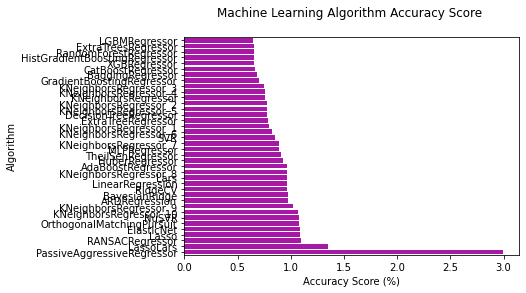

In [11]:
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [12]:
def objective(trial, y_test, predictions):
    weighted_predictions = np.zeros_like(predictions[0])
    for i in range(len(MLA)):
        # Assign a weight to each prediction
        weight = trial.suggest_float(f'w{i}', 0, 1)
        weighted_predictions += weight * predictions[i]
    weighted_predictions /= np.sum(weighted_predictions)  # Normalize weights

    # Calculate metric on your validation set
    mae = median_absolute_error(y_test, weighted_predictions)
    return mae

In [13]:
def weighted_avg_objective(trial, y_true, model_predictions):
    # The model_predictions is a list of prediction arrays from the three models
    weighted_predictions = np.zeros_like(model_predictions[0])
    total_weight = 0

    for i in range(len(model_predictions)):
        # Define the weight for each model
        weight = trial.suggest_float(f'w{i}', 0, 1)
        total_weight += weight
        weighted_predictions += weight * model_predictions[i]

    # Normalize the predictions by the total weight
    if total_weight > 0:
        weighted_predictions /= total_weight

    # Calculate the median absolute error
    return median_absolute_error(y_true, weighted_predictions)

In [14]:
# Hill Climbing inspired by code from Kaggle
def hill_climbing(x, y):
    
    # Evaluating oof predictions
    scores = {}
    for col in x.columns:
        scores[col] = median_absolute_error(y, x[col])

    # Sorting the model scores
    scores = {k: v for k, v in sorted(scores.items(), key = lambda item: item[1], reverse = True)}

    # Sort oof_df
    x = x[list(scores.keys())]

    STOP = False
    current_best_ensemble = x.iloc[:,0]
    MODELS = x.iloc[:,1:]
    weight_range = np.arange(-0.5, 0.51, 0.01) 
    history = [median_absolute_error(y, current_best_ensemble)]
    j = 0

    while not STOP:
        j += 1
        potential_new_best_cv_score = median_absolute_error(y, current_best_ensemble)
        k_best, wgt_best = None, None
        for k in MODELS:
            for wgt in weight_range:
                potential_ensemble = (1 - wgt) * current_best_ensemble + wgt * MODELS[k]
                cv_score = median_absolute_error(y, potential_ensemble)
                if cv_score < potential_new_best_cv_score:
                    potential_new_best_cv_score = cv_score
                    k_best, wgt_best = k, wgt

        if k_best is not None:
            current_best_ensemble = (1 - wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
            MODELS.drop(k_best, axis = 1, inplace = True)
            if MODELS.shape[1] == 0:
                STOP = True
            history.append(potential_new_best_cv_score)
        else:
            STOP = True
        
    hill_ens_pred = current_best_ensemble
    
    return hill_ens_pred

In [15]:
avg_predictions_scores = []
optuna_weights_scores = []
hill_climb_scores = []
stacked_scores = []
optuna_weights_scores_stack = []

for i, (train_index, test_index) in enumerate(cv_split.split(df_capped[num_var], df_capped[TARGET])):
    X_train, X_test = df_capped[num_var].iloc[train_index], df_capped[num_var].iloc[test_index]
    y_train, y_test = df_capped[TARGET].iloc[train_index], df_capped[TARGET].iloc[test_index]

    print(f'Fold {i+1}')
    
    MLA_cv_train_preds = []
    MLA_cv_preds = []
    MLA_cv_preds_dict = {}
    
    for alg in MLA:
        MLA_name = alg.__class__.__name__

        # Add suffix if name already exists
        suffix = 1
        original_MLA_name = MLA_name
        if MLA_name in MLA_cv_preds:
        # while MLA_cv_preds.str.contains(MLA_name).any():
            MLA_name = f"{original_MLA_name}_{suffix}"
            suffix += 1
            
        predictor = alg.fit(X_train, y_train)
        pred_train_result = predictor.predict(X_train)
        pred_result = predictor.predict(X_test)

        MLA_cv_train_preds.append(pred_train_result)
        MLA_cv_preds.append(pred_result)
        MLA_cv_preds_dict[MLA_name] = pred_result

    #################
    ### Averaging ###
    #################
    avg_prediction = np.mean(MLA_cv_preds, axis=0)
    avg_prediction_score = median_absolute_error(y_test, avg_prediction)
    avg_predictions_scores.append(avg_prediction_score)
    print(f'The Fold {i+1} average prediction is {avg_prediction_score}')

    ##############
    ### Optuna ###
    ##############
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, y_test, MLA_cv_preds), n_trials=200)

    # Use the best weights
    best_weights = [study.best_params[f'w{i}'] for i in range(len(MLA))]
    weighted_avg_predictions = np.average(MLA_cv_preds, axis=0, weights=best_weights)
    weighted_avg_predictions_score = median_absolute_error(y_test, weighted_avg_predictions)
    optuna_weights_scores.append(weighted_avg_predictions_score)
    print(f'The Fold {i+1} Optuna weights is {weighted_avg_predictions_score}')

    ##################
    ### Hill Climb ###
    ##################
    hill_climb_pred = hill_climbing(pd.DataFrame(MLA_cv_preds_dict), y_test)
    hill_climb_score = median_absolute_error(y_test, hill_climb_pred)
    hill_climb_scores.append(hill_climb_score)
    print(f'The Fold {i+1} Hill Climb is {hill_climb_score}')

    ###############################
    ### Simple 2-Level Stacking ###
    ###############################
    stacked_features = np.column_stack(MLA_cv_train_preds)
    stacked_test = np.column_stack(MLA_cv_preds)

    meta_model = LGBMRegressor(n_jobs=-1, random_state=5)
    meta_model.fit(stacked_features, y_train)
    stacked_prediction = meta_model.predict(stacked_test)
    stacked_score = median_absolute_error(y_test, stacked_prediction)
    stacked_scores.append(stacked_score)
    print(f'The Fold {i+1} 2-Level Stacked Score is {stacked_score}')

    ###############################################################
    ### 2-Level Multi-Model Stack with 3-Level Weighted Average ###
    ###############################################################
    # LGBM
    meta_model_lgbm = LGBMRegressor(n_jobs=-1, random_state=5)
    meta_model_lgbm.fit(stacked_features, y_train)
    stacked_prediction_lgbm = meta_model_lgbm.predict(stacked_test)
    stacked_score_lgbm = median_absolute_error(y_test, stacked_prediction_lgbm)

    # XGBRegressor(seed=5)
    meta_model_xgb = XGBRegressor(seed=5)
    meta_model_xgb.fit(stacked_features, y_train)
    stacked_prediction_xgb = meta_model_xgb.predict(stacked_test)
    stacked_score_xgb = median_absolute_error(y_test, stacked_prediction_xgb)

    # CatBoost
    meta_model_cat = CatBoostRegressor(random_state=5, verbose=False, early_stopping_rounds=100)
    meta_model_cat.fit(stacked_features, y_train)
    stacked_prediction_cat = meta_model_cat.predict(stacked_test)
    stacked_score_cat = median_absolute_error(y_test, stacked_prediction_cat)
    
    # Stack the predictions from your three models
    second_level_predictions = [
        stacked_prediction_lgbm,
        stacked_prediction_xgb,
        stacked_prediction_cat
    ]

    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: weighted_avg_objective(trial, y_test, second_level_predictions), n_trials=200)

    best_weights = [study.best_params[f'w{i}'] for i in range(len(second_level_predictions))]
    weighted_avg_prediction = np.average(second_level_predictions, axis=0, weights=best_weights)
    weighted_avg_score = median_absolute_error(y_test, weighted_avg_prediction)
    print(f"The Fold {i+1} 2-Level Multi-Model Stack with 3-Level Weighted Average Prediction Score: {weighted_avg_score}")
    optuna_weights_scores_stack.append(weighted_avg_score)
    print()

print()
print(f'The average prediction CV score is ==> {np.mean(avg_predictions_scores)}')
print(f'The Optuna weights CV score is ==> {np.mean(optuna_weights_scores)}')
print(f'The Hill Climbing CV score is ==> {np.mean(hill_climb_scores)}')
print(f'The 2-Level Stacking CV score is ==> {np.mean(stacked_scores)}')
print(f'The 2-Level Multi-Model Stack with 3-Level Weighted Average CV score is ==> {np.mean(optuna_weights_scores_stack)}')

Fold 1
The Fold 1 average prediction is 0.8887891300560469
The Fold 1 Optuna weights is 0.9701172478566074
The Fold 1 Hill Climb is 0.6117430816688247
The Fold 1 2-Level Stacked Score is 0.7999248353371868
The Fold 1 2-Level Multi-Model Stack with 3-Level Weighted Average Prediction Score: 0.6838910978443797

Fold 2
The Fold 2 average prediction is 0.8737634889031192
The Fold 2 Optuna weights is 0.9344609352852746
The Fold 2 Hill Climb is 0.5700602044001384
The Fold 2 2-Level Stacked Score is 0.799600353506249
The Fold 2 2-Level Multi-Model Stack with 3-Level Weighted Average Prediction Score: 0.6861392108037139

Fold 3
The Fold 3 average prediction is 0.9113309565961982
The Fold 3 Optuna weights is 0.8277448994601664
The Fold 3 Hill Climb is 0.6398080304009799
The Fold 3 2-Level Stacked Score is 0.7998339027504513
The Fold 3 2-Level Multi-Model Stack with 3-Level Weighted Average Prediction Score: 0.6926123788678753

Fold 4
The Fold 4 average prediction is 0.7677113953980257
The Fold 